![](q_learning.png)

$$
    (1 - \alpha) \cdot Q(S, A) + \alpha \ ( R + \gamma  \underset{a}{\max} Q(S', a))
$$

In [403]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output

import matplotlib.pyplot as plt
from collections import deque
import random

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError

import numpy as np

import gym
from gym.spaces import Discrete

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

GYM_NAME = 'MountainCar-v0'
ENV = gym.make(GYM_NAME)

EPISODES = 500
ALPHA = 0.7
GAMMA = 0.95
EPSILON = 0.1
TRAINING_SIZE = 1_000


if GYM_NAME == 'CartPole-v0':
    EPISODES = 500
    ALPHA = 0.7
    GAMMA = 0.95
    EPSILON = 0.1
    TRAINING_SIZE = 5000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [399]:
class EnviromentRunner:
    """Class used to run the enviroment and cache experience."""
    
    
    def __init__(
        self,
        memory_size=100_000,
        env=ENV,
        gym_name=GYM_NAME,
    ):
        
        self.memory_size = memory_size
        self.env = env    
        self.gym_name = gym_name
        
        self.experience = deque(maxlen=memory_size)
    
    
    def reward(self, state, action, new_reward, new_state, done, info):
        """Used to customize the reward function for a given gym."""
        
        if GYM_NAME == 'CartPole-v0':
            return -1 if done else new_reward
        
        elif GYM_NAME == 'MountainCar-v0':
            return new_state[0] + 0.5
        
        return new_reward
    

    def run(self, policy=None, verbose=0, exhibition=False):
        """Used to generate an episode."""

        # Start the enviroment an log the start state.
        state = self.env.reset()
        
        episode_length = 0
        total_reward = 0
        
        try:

            while True:

                if exhibition:
                    self.env.render()

                if policy is None:
                    action = self.env.action_space.sample()
                else: 
                    action = policy(state)

                new_state, new_reward, done, info = self.env.step(action) 

                # Recalculate reward.
                new_reward = self.reward(state, action, new_reward, new_state, done, info)

                # Save SARS
                self.experience.append(
                    (state, action, new_reward, new_state)
                )

                if verbose >= 2:
                    print(
                        f"\nepisode length: {episode_length}\n"
                        f"state: {state}\n"
                        f"action: {action} "
                        f"new_reward: {new_reward}\n"
                        f"new_state: {new_state}\n"
                    )


                # Current state is now the new state.
                state = new_state

                # For monitoring.
                episode_length += 1
                total_reward = total_reward + new_reward

                if done and not exhibition:
                    break
                

        finally: 
            
            self.env.close()
        
        if verbose >= 1:
            print(
                f"\ntotal episode length: {episode_length} "
                f"total reward: {total_reward} "
            )
        
        return episode_length, total_reward

        
enviroment_runner = EnviromentRunner()
enviroment_runner.run()
assert len(enviroment_runner.experience) > 0

In [400]:
class ActionValueApproximator:
    """A class which approximates the action value function."""
    
    
    def __init__(
        self, 
        env=ENV,
        alpha=ALPHA,
        gamma=GAMMA,
        epsilon=EPSILON,
        training_size=TRAINING_SIZE,
        X_pipeline = StandardScaler(),
        y_pipeline = StandardScaler(),
    ):

        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.training_size = training_size
        self.X_pipeline = X_pipeline
        self.y_pipeline = y_pipeline

        
        if isinstance(env.action_space, Discrete):
            self.input_dim = env.observation_space.shape[0] + 1
        else:
            self.input_dim = env.observation_space.shape[0] + env.action_space.shape[0]
        
        
        self.model = Sequential()
        self.model.add(Dense(24, input_dim=self.input_dim, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(1, activation='relu'))
        self.model.add(Activation('linear'))
        self.model.compile(
            optimizer=Adam(lr=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )
        
    
    def fit(self, X, y, fit_kwargs={
        'batch_size': 32, 
        'epochs': 10,
        'use_multiprocessing': True,
    }):
        """Train value approximator."""
        
        print('\nTrain...')
        # print(f"\nX:\n {X}\ny:\n {y}, total ys != alpha: {np.sum(y != self.alpha)}")
        # X = self.X_pipeline.fit_transform(X)
        # y = self.y_pipeline.fit_transform(y)
        self.model.fit(X, y, **fit_kwargs)
        return self
    
    
    def predict(self, X):
        """Predict based on preprocessed X."""
        try:
            # X = self.X_pipeline.transform(X)
            return self.model.predict(X)
        except NotFittedError:
            return np.random.randn(1, 1)
    
    
    def replay(self, experience):
        """Fit based on cached experience."""
        
        if len(experience) < self.training_size:
            return self
        
        Xs = []
        ys = []
        
        subsample = random.sample(experience, self.training_size)
        
        for sars in subsample:
            Xs.append(self.get_X(*sars))
            ys.append(self.get_y(*sars))
        
        X = np.concatenate(Xs)
        y = np.concatenate(ys)
        
        self.fit(X, y)
        return self

            
    def get_X(self, state, action, *args):
        """Get input."""
        return np.concatenate((state, np.array([action]))).reshape(1, -1)
    
    
    def get_y(self, state, action, new_reward, new_state):
        """Get the target value."""
        value_update = (
            new_reward + self.gamma * max(
                self.value(new_state, action)
                for action in range(self.env.action_space.n)
            )
        )
        return (1 - self.alpha) * self.value(state, action) + self.alpha * value_update 

    
    def value(self, state, action, *args):
        """The value of taking an action in a given state."""
        X = self.get_X(state, action)
        return self.predict(X)
    
    
    def policy(self, state):
        """Epsilon greedy policy using the value approximation."""
        
        # With probability `epsilon` take a random action.
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        
        # Best action.
        return np.argmax([
            self.value(state, action)
            for action in range(self.env.action_space.n)
        ])
    

In [385]:
value_approximator.get_y(*enviroment_runner.experience[3])

array([[-0.04558911]], dtype=float32)

# Run the model

You can break the cell whenever.

In [401]:
enviroment_runner = EnviromentRunner()
value_approximator = ActionValueApproximator()
runner_log = []


In [412]:

for episode in range(EPISODES):
    
    print(f"\n--- EPISODE {episode} ---")
    
    episode_length, total_reward = enviroment_runner.run(
        policy=value_approximator.policy,
        verbose=1
    )
    runner_log.append({'episode_length': episode_length, 'total_reward': total_reward})
    
    value_approximator.replay(
        enviroment_runner.experience
    )
    


--- EPISODE 0 ---

total episode length: 200 total reward: 23.464054579671366 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0032 - mae: 0.0312 - mse: 0.0032
Epoch 2/10
1000/1000 [==============================] - 0s 81us/step - loss: 0.0055 - mae: 0.0312 - mse: 0.0055
Epoch 3/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.0393 - mae: 0.0870 - mse: 0.0393
Epoch 4/10
1000/1000 [==============================] - 0s 80us/step - loss: 0.0994 - mae: 0.1575 - mse: 0.0994
Epoch 5/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.0414 - mae: 0.0907 - mse: 0.0414
Epoch 6/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.0202 - mae: 0.0882 - mse: 0.0202
Epoch 7/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0057 - mae: 0.0402 - mse: 0.0057
Epoch 8/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0025 - mae: 0.0271 - mse: 0.0025
Epoch 9/10
100

1000/1000 [==============================] - 0s 86us/step - loss: 0.0022 - mae: 0.0317 - mse: 0.0022  
Epoch 9/10
1000/1000 [==============================] - 0s 75us/step - loss: 0.0010 - mae: 0.0176 - mse: 0.0010   
Epoch 10/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0014 - mae: 0.0216 - mse: 0.0014  

--- EPISODE 7 ---

total episode length: 200 total reward: 24.703813741262966 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0073 - mae: 0.0337 - mse: 0.0073  
Epoch 2/10
1000/1000 [==============================] - 0s 83us/step - loss: 0.0546 - mae: 0.1590 - mse: 0.0546
Epoch 3/10
1000/1000 [==============================] - 0s 79us/step - loss: 0.0141 - mae: 0.0635 - mse: 0.0141
Epoch 4/10
1000/1000 [==============================] - 0s 79us/step - loss: 0.0124 - mae: 0.0716 - mse: 0.0124
Epoch 5/10
1000/1000 [==============================] - 0s 77us/step - loss: 0.0049 - mae: 0.0428 - mse: 0.0049
Epoch 6/10
1000

1000/1000 [==============================] - 0s 70us/step - loss: 0.0041 - mae: 0.0348 - mse: 0.0041  
Epoch 6/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.0040 - mae: 0.0352 - mse: 0.0040
Epoch 7/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0030 - mae: 0.0334 - mse: 0.0030
Epoch 8/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0013 - mae: 0.0197 - mse: 0.0013
Epoch 9/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0012 - mae: 0.0192 - mse: 0.0012  
Epoch 10/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0014 - mae: 0.0213 - mse: 0.0014

--- EPISODE 14 ---

total episode length: 200 total reward: 23.0389618681771 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0023 - mae: 0.0209 - mse: 0.0023  
Epoch 2/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0434 - mae: 0.0917 - mse: 0.0434
Epoch 3/10
1000/100

Epoch 2/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0073 - mae: 0.0528 - mse: 0.0073
Epoch 3/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0046 - mae: 0.0438 - mse: 0.0046
Epoch 4/10
1000/1000 [==============================] - 0s 76us/step - loss: 0.0034 - mae: 0.0303 - mse: 0.0034
Epoch 5/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0027 - mae: 0.0272 - mse: 0.0027
Epoch 6/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0018 - mae: 0.0234 - mse: 0.0018
Epoch 7/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0017 - mae: 0.0214 - mse: 0.0017  
Epoch 8/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0034 - mae: 0.0362 - mse: 0.0034
Epoch 9/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0026 - mae: 0.0292 - mse: 0.0026
Epoch 10/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0022 - mae: 0.0252 - m

1000/1000 [==============================] - 0s 74us/step - loss: 0.0067 - mae: 0.0585 - mse: 0.0067
Epoch 10/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0036 - mae: 0.0403 - mse: 0.0036

--- EPISODE 27 ---

total episode length: 200 total reward: 24.228617189103225 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 63us/step - loss: 0.0030 - mae: 0.0255 - mse: 0.0030  
Epoch 2/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0048 - mae: 0.0458 - mse: 0.0048
Epoch 3/10
1000/1000 [==============================] - 0s 77us/step - loss: 0.0039 - mae: 0.0302 - mse: 0.0039
Epoch 4/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0089 - mae: 0.0500 - mse: 0.0089  
Epoch 5/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0070 - mae: 0.0521 - mse: 0.0070
Epoch 6/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0088 - mae: 0.0604 - mse: 0.0088  
Epoch 7/10
1000/1

1000/1000 [==============================] - 0s 69us/step - loss: 0.0070 - mae: 0.0528 - mse: 0.0070
Epoch 7/10
1000/1000 [==============================] - 0s 84us/step - loss: 0.0110 - mae: 0.0663 - mse: 0.0110
Epoch 8/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0107 - mae: 0.0645 - mse: 0.0107
Epoch 9/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0028 - mae: 0.0272 - mse: 0.0028  
Epoch 10/10
1000/1000 [==============================] - 0s 77us/step - loss: 0.0077 - mae: 0.0424 - mse: 0.0077

--- EPISODE 34 ---

total episode length: 200 total reward: 21.50364004209948 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 64us/step - loss: 0.0149 - mae: 0.0642 - mse: 0.0149  
Epoch 2/10
1000/1000 [==============================] - 0s 86us/step - loss: 0.0264 - mae: 0.1067 - mse: 0.0264
Epoch 3/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0092 - mae: 0.0592 - mse: 0.0092
Epoch 4/10
1000/1000

1000/1000 [==============================] - 0s 72us/step - loss: 0.0022 - mae: 0.0198 - mse: 0.0022
Epoch 4/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0018 - mae: 0.0198 - mse: 0.0018  
Epoch 5/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0021 - mae: 0.0219 - mse: 0.0021
Epoch 6/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0041 - mae: 0.0345 - mse: 0.0041
Epoch 7/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0052 - mae: 0.0487 - mse: 0.0052
Epoch 8/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0202 - mae: 0.0938 - mse: 0.0202
Epoch 9/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.0199 - mae: 0.0854 - mse: 0.0199
Epoch 10/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.0038 - mae: 0.0406 - mse: 0.0038

--- EPISODE 41 ---

total episode length: 200 total reward: 23.768007343996356 

Train...
Epoch 1/10
1000/1000 

1000/1000 [==============================] - 0s 83us/step - loss: 0.0039 - mae: 0.0277 - mse: 0.0039

--- EPISODE 47 ---

total episode length: 200 total reward: 17.27783304910376 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 64us/step - loss: 0.0046 - mae: 0.0356 - mse: 0.0046
Epoch 2/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.0057 - mae: 0.0484 - mse: 0.0057
Epoch 3/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0468 - mae: 0.1352 - mse: 0.0468
Epoch 4/10
1000/1000 [==============================] - 0s 102us/step - loss: 0.0362 - mae: 0.1145 - mse: 0.0362
Epoch 5/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0308 - mae: 0.1132 - mse: 0.0308
Epoch 6/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0132 - mae: 0.0680 - mse: 0.0132
Epoch 7/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0093 - mae: 0.0633 - mse: 0.0093
Epoch 8/10
1000/1000 [==

1000/1000 [==============================] - 0s 72us/step - loss: 0.0026 - mae: 0.0324 - mse: 0.0026
Epoch 8/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0049 - mae: 0.0355 - mse: 0.0049
Epoch 9/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0107 - mae: 0.0640 - mse: 0.0107
Epoch 10/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0047 - mae: 0.0463 - mse: 0.0047

--- EPISODE 54 ---

total episode length: 200 total reward: 23.498335202384585 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0049 - mae: 0.0315 - mse: 0.0049  
Epoch 2/10
1000/1000 [==============================] - 0s 78us/step - loss: 0.0025 - mae: 0.0215 - mse: 0.0025
Epoch 3/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.0017 - mae: 0.0239 - mse: 0.0017
Epoch 4/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0024 - mae: 0.0306 - mse: 0.0024
Epoch 5/10
1000/1000 

1000/1000 [==============================] - 0s 68us/step - loss: 0.0861 - mae: 0.1868 - mse: 0.0861
Epoch 5/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0197 - mae: 0.0802 - mse: 0.0197
Epoch 6/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0143 - mae: 0.0778 - mse: 0.0143
Epoch 7/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0048 - mae: 0.0369 - mse: 0.0048
Epoch 8/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0070 - mae: 0.0490 - mse: 0.0070
Epoch 9/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.0037 - mae: 0.0377 - mse: 0.0037  
Epoch 10/10
1000/1000 [==============================] - 0s 72us/step - loss: 0.0028 - mae: 0.0331 - mse: 0.0028  

--- EPISODE 61 ---

total episode length: 200 total reward: 24.726440172000437 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0038 - mae: 0.0336 - mse: 0.0038  
Epoch 2/10
1000/1


Train...
Epoch 1/10
1000/1000 [==============================] - 0s 80us/step - loss: 0.0102 - mae: 0.0409 - mse: 0.0102
Epoch 2/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0130 - mae: 0.0773 - mse: 0.0130
Epoch 3/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0053 - mae: 0.0398 - mse: 0.0053
Epoch 4/10
1000/1000 [==============================] - 0s 76us/step - loss: 0.0066 - mae: 0.0399 - mse: 0.0066
Epoch 5/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0037 - mae: 0.0356 - mse: 0.0037  
Epoch 6/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0034 - mae: 0.0307 - mse: 0.0034  
Epoch 7/10
1000/1000 [==============================] - 0s 73us/step - loss: 0.0024 - mae: 0.0284 - mse: 0.0024
Epoch 8/10
1000/1000 [==============================] - 0s 87us/step - loss: 0.0025 - mae: 0.0233 - mse: 0.0025
Epoch 9/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0021 - mae:

1000/1000 [==============================] - 0s 72us/step - loss: 0.0174 - mae: 0.0232 - mse: 0.0174
Epoch 9/10
1000/1000 [==============================] - 0s 70us/step - loss: 0.0168 - mae: 0.0183 - mse: 0.0168  
Epoch 10/10
1000/1000 [==============================] - 0s 77us/step - loss: 0.0178 - mae: 0.0292 - mse: 0.0178  

--- EPISODE 74 ---

total episode length: 200 total reward: 24.21913991477342 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0210 - mae: 0.0326 - mse: 0.0210
Epoch 2/10
1000/1000 [==============================] - 0s 85us/step - loss: 0.0238 - mae: 0.0606 - mse: 0.0238
Epoch 3/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0215 - mae: 0.0409 - mse: 0.0215
Epoch 4/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0266 - mae: 0.0607 - mse: 0.0266
Epoch 5/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0413 - mae: 0.0760 - mse: 0.0413
Epoch 6/10
1000/1000

1000/1000 [==============================] - 0s 74us/step - loss: 0.0309 - mae: 0.0979 - mse: 0.0309
Epoch 6/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0321 - mae: 0.1022 - mse: 0.0321
Epoch 7/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0108 - mae: 0.0666 - mse: 0.0108
Epoch 8/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0036 - mae: 0.0350 - mse: 0.0036
Epoch 9/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0038 - mae: 0.0338 - mse: 0.0038
Epoch 10/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0034 - mae: 0.0264 - mse: 0.0034  

--- EPISODE 81 ---

total episode length: 200 total reward: 24.723827052821694 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0256 - mae: 0.0777 - mse: 0.0256
Epoch 2/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0165 - mae: 0.0491 - mse: 0.0165
Epoch 3/10
1000/1000 

1000/1000 [==============================] - 0s 60us/step - loss: 0.0038 - mae: 0.0330 - mse: 0.0038  
Epoch 2/10
1000/1000 [==============================] - 0s 64us/step - loss: 0.0031 - mae: 0.0313 - mse: 0.0031
Epoch 3/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0020 - mae: 0.0211 - mse: 0.0020
Epoch 4/10
1000/1000 [==============================] - 0s 76us/step - loss: 0.0018 - mae: 0.0218 - mse: 0.0018
Epoch 5/10
1000/1000 [==============================] - 0s 71us/step - loss: 0.0017 - mae: 0.0203 - mse: 0.0017  
Epoch 6/10
1000/1000 [==============================] - 0s 69us/step - loss: 0.0017 - mae: 0.0221 - mse: 0.0017
Epoch 7/10
1000/1000 [==============================] - 0s 63us/step - loss: 0.0039 - mae: 0.0357 - mse: 0.0039
Epoch 8/10
1000/1000 [==============================] - 0s 76us/step - loss: 0.0045 - mae: 0.0368 - mse: 0.0045  
Epoch 9/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0020 - mae: 0.0219 - mse: 0.00

1000/1000 [==============================] - 0s 48us/step - loss: 0.0032 - mae: 0.0335 - mse: 0.0032
Epoch 9/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0016 - mae: 0.0217 - mse: 0.0016   
Epoch 10/10
1000/1000 [==============================] - 0s 63us/step - loss: 0.0021 - mae: 0.0252 - mse: 0.0021

--- EPISODE 94 ---

total episode length: 200 total reward: 23.286017908051843 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0053 - mae: 0.0361 - mse: 0.0053   
Epoch 2/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0044 - mae: 0.0382 - mse: 0.0044
Epoch 3/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0033 - mae: 0.0283 - mse: 0.0033
Epoch 4/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0080 - mae: 0.0557 - mse: 0.0080   
Epoch 5/10
1000/1000 [==============================] - 0s 48us/step - loss: 0.1446 - mae: 0.2050 - mse: 0.1446
Epoch 6/10
100

1000/1000 [==============================] - 0s 52us/step - loss: 0.0020 - mae: 0.0216 - mse: 0.0020
Epoch 5/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0021 - mae: 0.0250 - mse: 0.0021
Epoch 6/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0029 - mae: 0.0326 - mse: 0.0029
Epoch 7/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.0010 - mae: 0.0180 - mse: 0.0010
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0023 - mae: 0.0265 - mse: 0.0023   
Epoch 9/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.0030 - mae: 0.0354 - mse: 0.0030
Epoch 10/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0099 - mae: 0.0561 - mse: 0.0099   

--- EPISODE 101 ---

total episode length: 200 total reward: 23.21964727703507 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0334 - mae: 0.0616 - mse: 0.0334   
Epoch 2/10
100


total episode length: 200 total reward: 23.14376985529998 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0030 - mae: 0.0228 - mse: 0.0030   
Epoch 2/10
1000/1000 [==============================] - 0s 77us/step - loss: 0.0021 - mae: 0.0218 - mse: 0.0021  
Epoch 3/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0020 - mae: 0.0260 - mse: 0.0020  
Epoch 4/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0060 - mae: 0.0479 - mse: 0.0060
Epoch 5/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0020 - mae: 0.0290 - mse: 0.0020
Epoch 6/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0014 - mae: 0.0182 - mse: 0.0014
Epoch 7/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0020 - mae: 0.0243 - mse: 0.0020   
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0028 - mae: 0.0248 - mse: 0.0028
Epoch 9/10
1000/1000 [==

1000/1000 [==============================] - 0s 59us/step - loss: 0.0096 - mae: 0.0558 - mse: 0.0096
Epoch 9/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0064 - mae: 0.0480 - mse: 0.0064
Epoch 10/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0060 - mae: 0.0444 - mse: 0.0060

--- EPISODE 114 ---

total episode length: 200 total reward: 24.415879812897078 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0049 - mae: 0.0294 - mse: 0.0049   
Epoch 2/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0038 - mae: 0.0293 - mse: 0.0038
Epoch 3/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.0043 - mae: 0.0263 - mse: 0.0043  
Epoch 4/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0058 - mae: 0.0347 - mse: 0.0058
Epoch 5/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0047 - mae: 0.0258 - mse: 0.0047   
Epoch 6/10
100

1000/1000 [==============================] - 0s 54us/step - loss: 0.4251 - mae: 0.3712 - mse: 0.4251
Epoch 5/10
1000/1000 [==============================] - 0s 67us/step - loss: 0.0719 - mae: 0.1551 - mse: 0.0719
Epoch 6/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0250 - mae: 0.0898 - mse: 0.0250
Epoch 7/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0113 - mae: 0.0545 - mse: 0.0113
Epoch 8/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0084 - mae: 0.0573 - mse: 0.0084
Epoch 9/10
1000/1000 [==============================] - 0s 48us/step - loss: 0.0034 - mae: 0.0281 - mse: 0.0034
Epoch 10/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0121 - mae: 0.0580 - mse: 0.0121   

--- EPISODE 121 ---

total episode length: 200 total reward: 24.041430478018874 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0115 - mae: 0.0449 - mse: 0.0115
Epoch 2/10
1000/100

1000/1000 [==============================] - 0s 50us/step - loss: 0.0042 - mae: 0.0312 - mse: 0.0042   
Epoch 2/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0258 - mae: 0.1065 - mse: 0.0258   
Epoch 3/10
1000/1000 [==============================] - 0s 63us/step - loss: 0.0417 - mae: 0.0919 - mse: 0.0417
Epoch 4/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.1191 - mae: 0.2103 - mse: 0.1191
Epoch 5/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.1124 - mae: 0.2193 - mse: 0.1124
Epoch 6/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.0193 - mae: 0.0763 - mse: 0.0193
Epoch 7/10
1000/1000 [==============================] - 0s 47us/step - loss: 0.0108 - mae: 0.0718 - mse: 0.0108
Epoch 8/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0081 - mae: 0.0512 - mse: 0.0081
Epoch 9/10
1000/1000 [==============================] - 0s 48us/step - loss: 0.0034 - mae: 0.0270 - mse: 0.00

1000/1000 [==============================] - 0s 52us/step - loss: 0.0253 - mae: 0.0678 - mse: 0.0253
Epoch 9/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0170 - mae: 0.0712 - mse: 0.0170
Epoch 10/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0073 - mae: 0.0523 - mse: 0.0073  

--- EPISODE 134 ---

total episode length: 200 total reward: 23.117612418973422 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 47us/step - loss: 0.0355 - mae: 0.0408 - mse: 0.0355
Epoch 2/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0308 - mae: 0.0428 - mse: 0.0308
Epoch 3/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0330 - mae: 0.0566 - mse: 0.0330
Epoch 4/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0301 - mae: 0.0558 - mse: 0.0301
Epoch 5/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0715 - mae: 0.1321 - mse: 0.0715   
Epoch 6/10
1000/1

Epoch 5/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0026 - mae: 0.0211 - mse: 0.0026   
Epoch 6/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0040 - mae: 0.0357 - mse: 0.0040   
Epoch 7/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0102 - mae: 0.0565 - mse: 0.0102
Epoch 8/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0269 - mae: 0.0961 - mse: 0.0269
Epoch 9/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.0094 - mae: 0.0572 - mse: 0.0094
Epoch 10/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0055 - mae: 0.0466 - mse: 0.0055

--- EPISODE 141 ---

total episode length: 200 total reward: 23.594711220469087 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0044 - mae: 0.0263 - mse: 0.0044
Epoch 2/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0056 - mae: 0.0382 - mse: 0.0056
Epoch

1000/1000 [==============================] - 0s 54us/step - loss: 0.0021 - mae: 0.0236 - mse: 0.0021
Epoch 3/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0017 - mae: 0.0220 - mse: 0.0017
Epoch 4/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0015 - mae: 0.0207 - mse: 0.0015
Epoch 5/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0018 - mae: 0.0240 - mse: 0.0018
Epoch 6/10
1000/1000 [==============================] - 0s 64us/step - loss: 0.0023 - mae: 0.0295 - mse: 0.0023  
Epoch 7/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0022 - mae: 0.0251 - mse: 0.0022
Epoch 8/10
1000/1000 [==============================] - 0s 56us/step - loss: 0.0015 - mae: 0.0215 - mse: 0.0015
Epoch 9/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0041 - mae: 0.0335 - mse: 0.0041  
Epoch 10/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0039 - mae: 0.0388 - mse: 0.003

1000/1000 [==============================] - 0s 58us/step - loss: 0.0020 - mae: 0.0289 - mse: 0.0020
Epoch 10/10
1000/1000 [==============================] - 0s 59us/step - loss: 8.2459e-04 - mae: 0.0141 - mse: 8.2459e-04

--- EPISODE 154 ---

total episode length: 200 total reward: 23.21820204784788 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0069 - mae: 0.0448 - mse: 0.0069
Epoch 2/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0238 - mae: 0.0800 - mse: 0.0238
Epoch 3/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0115 - mae: 0.0723 - mse: 0.0115
Epoch 4/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0420 - mae: 0.1261 - mse: 0.0420
Epoch 5/10
1000/1000 [==============================] - 0s 79us/step - loss: 0.1149 - mae: 0.1904 - mse: 0.1149
Epoch 6/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0552 - mae: 0.1368 - mse: 0.0552
Epoch 7/10
1000

1000/1000 [==============================] - 0s 55us/step - loss: 0.0069 - mae: 0.0484 - mse: 0.0069
Epoch 7/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0087 - mae: 0.0516 - mse: 0.0087
Epoch 8/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0037 - mae: 0.0342 - mse: 0.0037
Epoch 9/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0053 - mae: 0.0370 - mse: 0.0053
Epoch 10/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0123 - mae: 0.0493 - mse: 0.0123

--- EPISODE 161 ---

total episode length: 200 total reward: 5.825104046296508 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0047 - mae: 0.0397 - mse: 0.0047
Epoch 2/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0039 - mae: 0.0325 - mse: 0.0039
Epoch 3/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0022 - mae: 0.0222 - mse: 0.0022
Epoch 4/10
1000/1000 [=

1000/1000 [==============================] - 0s 52us/step - loss: 0.0026 - mae: 0.0286 - mse: 0.0026
Epoch 4/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0035 - mae: 0.0411 - mse: 0.0035
Epoch 5/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0037 - mae: 0.0352 - mse: 0.0037
Epoch 6/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0051 - mae: 0.0382 - mse: 0.0051
Epoch 7/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0051 - mae: 0.0531 - mse: 0.0051
Epoch 8/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0024 - mae: 0.0285 - mse: 0.0024
Epoch 9/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0027 - mae: 0.0285 - mse: 0.0027
Epoch 10/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0031 - mae: 0.0402 - mse: 0.0031

--- EPISODE 168 ---

total episode length: 200 total reward: 23.318335049116122 

Train...
Epoch 1/10
1000/1000 [

1000/1000 [==============================] - 0s 52us/step - loss: 0.0104 - mae: 0.0521 - mse: 0.0104

--- EPISODE 174 ---

total episode length: 200 total reward: 23.56116323355207 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0180 - mae: 0.0854 - mse: 0.0180
Epoch 2/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0071 - mae: 0.0508 - mse: 0.0071
Epoch 3/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0188 - mae: 0.0466 - mse: 0.0188   
Epoch 4/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.0315 - mae: 0.1181 - mse: 0.0315
Epoch 5/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0059 - mae: 0.0514 - mse: 0.0059
Epoch 6/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0025 - mae: 0.0228 - mse: 0.0025
Epoch 7/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0040 - mae: 0.0338 - mse: 0.0040   
Epoch 8/10
1000/10

1000/1000 [==============================] - 0s 59us/step - loss: 0.0015 - mae: 0.0209 - mse: 0.0015
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0012 - mae: 0.0170 - mse: 0.0012   
Epoch 9/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0010 - mae: 0.0163 - mse: 0.0010   
Epoch 10/10
1000/1000 [==============================] - 0s 54us/step - loss: 9.3250e-04 - mae: 0.0142 - mse: 9.3250e-04

--- EPISODE 181 ---

total episode length: 200 total reward: 23.055149896925 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0018 - mae: 0.0181 - mse: 0.0018
Epoch 2/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0018 - mae: 0.0228 - mse: 0.0018
Epoch 3/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0015 - mae: 0.0216 - mse: 0.0015   
Epoch 4/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0013 - mae: 0.0173 - mse: 0.0013
Epoch 5/

1000/1000 [==============================] - 0s 52us/step - loss: 0.0030 - mae: 0.0262 - mse: 0.0030
Epoch 4/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0026 - mae: 0.0241 - mse: 0.0026
Epoch 5/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0031 - mae: 0.0279 - mse: 0.0031
Epoch 6/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0028 - mae: 0.0244 - mse: 0.0028
Epoch 7/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0019 - mae: 0.0222 - mse: 0.0019
Epoch 8/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0019 - mae: 0.0242 - mse: 0.0019  
Epoch 9/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.0023 - mae: 0.0274 - mse: 0.0023
Epoch 10/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0017 - mae: 0.0201 - mse: 0.0017

--- EPISODE 188 ---

total episode length: 200 total reward: 24.286062611004443 

Train...
Epoch 1/10
1000/1000

1000/1000 [==============================] - 0s 52us/step - loss: 0.0064 - mae: 0.0523 - mse: 0.0064

--- EPISODE 194 ---

total episode length: 200 total reward: 22.917141128685504 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0045 - mae: 0.0344 - mse: 0.0045
Epoch 2/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0022 - mae: 0.0224 - mse: 0.0022
Epoch 3/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0023 - mae: 0.0296 - mse: 0.0023
Epoch 4/10
1000/1000 [==============================] - 0s 62us/step - loss: 0.0018 - mae: 0.0218 - mse: 0.0018  
Epoch 5/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0040 - mae: 0.0438 - mse: 0.0040
Epoch 6/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0048 - mae: 0.0338 - mse: 0.0048
Epoch 7/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0021 - mae: 0.0283 - mse: 0.0021  
Epoch 8/10
1000/100

1000/1000 [==============================] - 0s 53us/step - loss: 0.0019 - mae: 0.0196 - mse: 0.0019   
Epoch 7/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0011 - mae: 0.0141 - mse: 0.0011   
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 9.6523e-04 - mae: 0.0141 - mse: 9.6523e-04
Epoch 9/10
1000/1000 [==============================] - 0s 50us/step - loss: 9.2072e-04 - mae: 0.0135 - mse: 9.2072e-04
Epoch 10/10
1000/1000 [==============================] - 0s 59us/step - loss: 9.6595e-04 - mae: 0.0151 - mse: 9.6595e-04

--- EPISODE 201 ---

total episode length: 200 total reward: 23.33724663954378 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0088 - mae: 0.0403 - mse: 0.0088   
Epoch 2/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0070 - mae: 0.0502 - mse: 0.0070
Epoch 3/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0032 - mae: 0.0347 - ms

1000/1000 [==============================] - 0s 53us/step - loss: 0.0114 - mae: 0.0673 - mse: 0.0114
Epoch 3/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0361 - mae: 0.0853 - mse: 0.0361
Epoch 4/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0187 - mae: 0.0863 - mse: 0.0187
Epoch 5/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0101 - mae: 0.0665 - mse: 0.0101
Epoch 6/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0041 - mae: 0.0344 - mse: 0.0041
Epoch 7/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0030 - mae: 0.0310 - mse: 0.0030
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0037 - mae: 0.0378 - mse: 0.0037
Epoch 9/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0051 - mae: 0.0383 - mse: 0.0051
Epoch 10/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0030 - mae: 0.0389 - mse: 0.0030

-

1000/1000 [==============================] - 0s 54us/step - loss: 0.0029 - mae: 0.0337 - mse: 0.0029

--- EPISODE 214 ---

total episode length: 200 total reward: 24.058054968866873 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0025 - mae: 0.0263 - mse: 0.0025
Epoch 2/10
1000/1000 [==============================] - 0s 47us/step - loss: 0.0032 - mae: 0.0306 - mse: 0.0032
Epoch 3/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0024 - mae: 0.0240 - mse: 0.0024   
Epoch 4/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0012 - mae: 0.0169 - mse: 0.0012   
Epoch 5/10
1000/1000 [==============================] - 0s 57us/step - loss: 9.8227e-04 - mae: 0.0130 - mse: 9.8227e-04
Epoch 6/10
1000/1000 [==============================] - 0s 55us/step - loss: 0.0028 - mae: 0.0306 - mse: 0.0028
Epoch 7/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0017 - mae: 0.0241 - mse: 0.0017
Epoch 8/1

1000/1000 [==============================] - 0s 48us/step - loss: 0.0074 - mae: 0.0444 - mse: 0.0074
Epoch 8/10
1000/1000 [==============================] - 0s 56us/step - loss: 0.0053 - mae: 0.0373 - mse: 0.0053
Epoch 9/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0025 - mae: 0.0204 - mse: 0.0025
Epoch 10/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0028 - mae: 0.0264 - mse: 0.0028

--- EPISODE 221 ---

total episode length: 200 total reward: 21.091547084331637 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0625 - mae: 0.1051 - mse: 0.0625
Epoch 2/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0193 - mae: 0.0558 - mse: 0.0193  
Epoch 3/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0207 - mae: 0.0667 - mse: 0.0207
Epoch 4/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0387 - mae: 0.1086 - mse: 0.0387
Epoch 5/10
1000/1000

1000/1000 [==============================] - 0s 52us/step - loss: 0.0150 - mae: 0.0621 - mse: 0.0150
Epoch 5/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0094 - mae: 0.0431 - mse: 0.0094
Epoch 6/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0060 - mae: 0.0337 - mse: 0.0060
Epoch 7/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0047 - mae: 0.0276 - mse: 0.0047   
Epoch 8/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0036 - mae: 0.0280 - mse: 0.0036
Epoch 9/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0085 - mae: 0.0571 - mse: 0.0085
Epoch 10/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0168 - mae: 0.0755 - mse: 0.0168

--- EPISODE 228 ---

total episode length: 200 total reward: 9.257531691950655 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0064 - mae: 0.0381 - mse: 0.0064
Epoch 2/10
1000/1000

1000/1000 [==============================] - 0s 52us/step - loss: 0.0080 - mae: 0.0372 - mse: 0.0080
Epoch 2/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0093 - mae: 0.0341 - mse: 0.0093
Epoch 3/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0051 - mae: 0.0324 - mse: 0.0051
Epoch 4/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0047 - mae: 0.0273 - mse: 0.0047
Epoch 5/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0063 - mae: 0.0342 - mse: 0.0063
Epoch 6/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0069 - mae: 0.0389 - mse: 0.0069
Epoch 7/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0033 - mae: 0.0240 - mse: 0.0033
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0194 - mae: 0.0671 - mse: 0.0194
Epoch 9/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0150 - mae: 0.0649 - mse: 0.0150
Epo

Epoch 9/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0544 - mae: 0.1698 - mse: 0.0544
Epoch 10/10
1000/1000 [==============================] - 0s 59us/step - loss: 0.0166 - mae: 0.0877 - mse: 0.0166

--- EPISODE 241 ---

total episode length: 200 total reward: 24.811500332802108 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0136 - mae: 0.0560 - mse: 0.0136
Epoch 2/10
1000/1000 [==============================] - 0s 56us/step - loss: 0.0105 - mae: 0.0629 - mse: 0.0105
Epoch 3/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0153 - mae: 0.0699 - mse: 0.0153
Epoch 4/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0188 - mae: 0.0675 - mse: 0.0188
Epoch 5/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0294 - mae: 0.0928 - mse: 0.0294
Epoch 6/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0352 - mae: 0.1117 - mse: 0.0352
Epoch 7/10


1000/1000 [==============================] - 0s 50us/step - loss: 0.0110 - mae: 0.0593 - mse: 0.0110
Epoch 7/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0290 - mae: 0.0790 - mse: 0.0290
Epoch 8/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0075 - mae: 0.0662 - mse: 0.0075
Epoch 9/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0018 - mae: 0.0247 - mse: 0.0018
Epoch 10/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0024 - mae: 0.0229 - mse: 0.0024  

--- EPISODE 248 ---

total episode length: 200 total reward: 24.0547630901867 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0413 - mae: 0.0585 - mse: 0.0413
Epoch 2/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0369 - mae: 0.0801 - mse: 0.0369
Epoch 3/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0313 - mae: 0.0861 - mse: 0.0313
Epoch 4/10
1000/1000 [

1000/1000 [==============================] - 0s 58us/step - loss: 0.0034 - mae: 0.0277 - mse: 0.0034
Epoch 4/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0125 - mae: 0.0359 - mse: 0.0125
Epoch 5/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0065 - mae: 0.0432 - mse: 0.0065
Epoch 6/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0051 - mae: 0.0327 - mse: 0.0051   
Epoch 7/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0032 - mae: 0.0300 - mse: 0.0032
Epoch 8/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0037 - mae: 0.0328 - mse: 0.0037
Epoch 9/10
1000/1000 [==============================] - 0s 68us/step - loss: 0.0019 - mae: 0.0178 - mse: 0.0019
Epoch 10/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0016 - mae: 0.0169 - mse: 0.0016

--- EPISODE 255 ---

total episode length: 200 total reward: 22.101396982075247 

Train...
Epoch 1/10
1000/100

1000/1000 [==============================] - 0s 60us/step - loss: 0.0526 - mae: 0.1126 - mse: 0.0526  

--- EPISODE 261 ---

total episode length: 200 total reward: -4.652312411911051 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 57us/step - loss: 0.0071 - mae: 0.0372 - mse: 0.0071
Epoch 2/10
1000/1000 [==============================] - 0s 56us/step - loss: 0.0037 - mae: 0.0352 - mse: 0.0037
Epoch 3/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0030 - mae: 0.0268 - mse: 0.0030   
Epoch 4/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0037 - mae: 0.0294 - mse: 0.0037
Epoch 5/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0033 - mae: 0.0324 - mse: 0.0033
Epoch 6/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0021 - mae: 0.0230 - mse: 0.0021   
Epoch 7/10
1000/1000 [==============================] - 0s 58us/step - loss: 0.0016 - mae: 0.0208 - mse: 0.0016  
Epoch 8/10
10

1000/1000 [==============================] - 0s 64us/step - loss: 0.0044 - mae: 0.0256 - mse: 0.0044  
Epoch 7/10
1000/1000 [==============================] - 0s 54us/step - loss: 0.0037 - mae: 0.0287 - mse: 0.0037
Epoch 8/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0052 - mae: 0.0364 - mse: 0.0052
Epoch 9/10
1000/1000 [==============================] - 0s 50us/step - loss: 0.0119 - mae: 0.0558 - mse: 0.0119   
Epoch 10/10
1000/1000 [==============================] - 0s 61us/step - loss: 0.0130 - mae: 0.0560 - mse: 0.0130

--- EPISODE 268 ---

total episode length: 200 total reward: 23.94418203425519 

Train...
Epoch 1/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0284 - mae: 0.0425 - mse: 0.0284
Epoch 2/10
1000/1000 [==============================] - 0s 65us/step - loss: 0.0199 - mae: 0.0445 - mse: 0.0199
Epoch 3/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0232 - mae: 0.0366 - mse: 0.0232   
Epoch 4/10
1000

1000/1000 [==============================] - 0s 52us/step - loss: 0.0254 - mae: 0.0780 - mse: 0.0254
Epoch 3/10
1000/1000 [==============================] - 0s 56us/step - loss: 0.0231 - mae: 0.0754 - mse: 0.0231
Epoch 4/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0086 - mae: 0.0384 - mse: 0.0086
Epoch 5/10
1000/1000 [==============================] - 0s 49us/step - loss: 0.0185 - mae: 0.0603 - mse: 0.0185
Epoch 6/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.0160 - mae: 0.0672 - mse: 0.0160
Epoch 7/10
1000/1000 [==============================] - 0s 60us/step - loss: 0.0194 - mae: 0.0631 - mse: 0.0194
Epoch 8/10
1000/1000 [==============================] - 0s 53us/step - loss: 0.0286 - mae: 0.0648 - mse: 0.0286   
Epoch 9/10
1000/1000 [==============================] - 0s 52us/step - loss: 0.0584 - mae: 0.1428 - mse: 0.0584
Epoch 10/10
1000/1000 [==============================] - 0s 51us/step - loss: 0.1066 - mae: 0.1244 - mse: 0.1066

1000/1000 [==============================] - 0s 84us/step - loss: 0.0033 - mae: 0.0257 - mse: 0.0033  

--- EPISODE 281 ---

total episode length: 200 total reward: 23.480525201238013 


KeyboardInterrupt: 

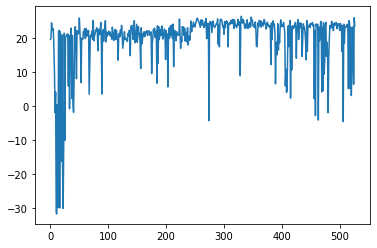

In [413]:
total_rewards = np.array(list(map(lambda log: log['total_reward'], runner_log)))
plt.plot(total_rewards)

In [414]:
value_approximator.epsilon = 0.0
enviroment_runner.run(
    policy=value_approximator.policy,
    exhibition=True,
    verbose=True
)

KeyboardInterrupt: 